In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
    
query1='''
SELECT
    *
FROM
    heartdisease
'''
    
    
df = pd.read_sql_query(query1, con=engine)
engine.dispose()

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [8]:
 # Define the features and the outcome
 X = df.iloc[:, :13]
 y = df.iloc[:, 13]

 # Replace missing values (marked by `?`) with a `0`
 X = X.replace(to_replace='?', value=0)

 # Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
 y = np.where(y > 0, 0, 1)

### Get the silhouette coefficient of the two cluster solution

In [10]:
# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [11]:
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.5817500491982808


#### Why is the silhouette coefficient higher for the two cluster solution than for the correct 3 cluster solution?

Because the silhouette score is an objective measurement and the correct solution to a clustering problem is always subjective.

#### Split the data randomly into two. Apply k-means using two, three, and four as the number of clusters, as you did when you were exploring consistency earlier in this checkpoint. Assess the consistency of the solutions using visualization. Which one seems to be the best?

In [16]:
# compute 2 dimensional PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)


# Split each into equal halves
X_1, X_2, pca_1, pca_2 = train_test_split(X_std, X_pca, test_size=.5)

In [17]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_1, pca_1),
    (X_2, pca_2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

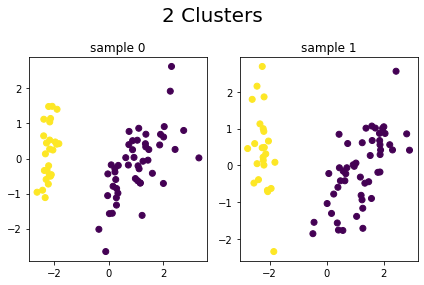

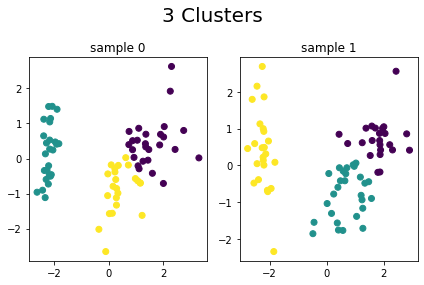

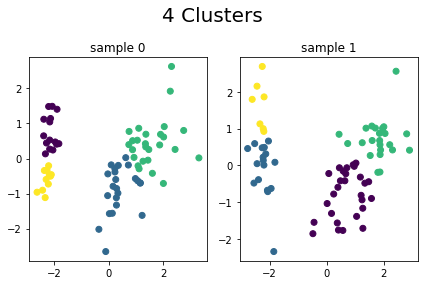

In [18]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Considering only consistency, all three solutions seem equally acceptable. Visually two and three clusters still seem valid

#### Apply k-means on the whole dataset by setting k equal to 2, 3, and 4. Get the ARI score for each of them. Which model is best?

In [21]:
# define a function
def score(k, X, y):
    pred = KMeans(n_clusters=k, random_state=123).fit_predict(X)
    
    return metrics.adjusted_rand_score(y, pred)
    
# get the score for each value of k
for k in [2,3,4]:
    print('ARI Score for k = {}'.format(k))
    print(score(k, X, y))

ARI Score for k = 2
0.5399218294207123
ARI Score for k = 3
0.7302382722834697
ARI Score for k = 4
0.6498176853819967


According to the ARI three clusters is best. Notably the correct number of clusters scores worst. 

#### Apply k-means on the whole dataset by setting k equal to 2, 3, and 4. Get the silhouette coefficient for each of them. Which model is best?

In [23]:
# define a function
def score(k, X, y):
    pred = KMeans(n_clusters=k, random_state=123).fit_predict(X)
    
    return metrics.silhouette_score(X, pred, metric='euclidean')
    
# get the score for each value of k
for k in [2,3,4]:
    print('ARI Score for k = {}'.format(k))
    print(score(k, X, y))

ARI Score for k = 2
0.681046169211746
ARI Score for k = 3
0.5528190123564091
ARI Score for k = 4
0.4980505049972866


Here however, the correct number of clusters performs best. Additionally the score gets worse the farther from the ground truth the number of clusters is set.